# Etapa 3 – Banco de Dados

Este notebook corresponde à Etapa 3 do teste técnico da IntuitiveCare.

Objetivos:
- Baixar os arquivos de demonstrações contábeis dos últimos 2 anos
- Baixar os dados cadastrais das operadoras ativas na ANS
- Estruturar e importar os dados para um banco relacional
- Elaborar queries analíticas

Tecnologia: PostgreSQL 13+ (via Docker)

In [ ]:
from google.colab import drive
import os

# Montar o Google Drive
drive.mount('/content/drive')

# Mudar para a raiz do projeto
os.chdir('/content/drive/MyDrive/intuitivecare_teste_tecnico')

# Verificar diretório atual
print("Diretório atual:", os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Diretório atual: /content/drive/MyDrive/intuitivecare_teste_tecnico


Analisando colunas do primeiro trimestre de 2023 (demonstrações contábeis)

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

caminho_1T2023 = "content/banco_de_dados/demonstracoes_contabeis/2023/1T2023.csv"

df_demo = pd.read_csv(caminho_1T2023, sep=';', encoding='latin1')

print("Colunas disponíveis:")
print(df_demo.columns.tolist())
display(df_demo.head())

Colunas disponíveis:
['DATA', 'REG_ANS', 'CD_CONTA_CONTABIL', 'DESCRICAO', 'VL_SALDO_INICIAL', 'VL_SALDO_FINAL']


,DATA,REG_ANS,CD_CONTA_CONTABIL,DESCRICAO,VL_SALDO_INICIAL,VL_SALDO_FINAL
0,2023-01-01,360783,12391,OUTROS CRÃDITOS DE OPERAÃÃES DE ASSISTÃNCI...,0,0
1,2023-01-01,360783,123911,Cobertura Assistencial com PreÃ§o Preestabelecido,0,0
2,2023-01-01,360783,12391101,Resseguros,0,0
3,2023-01-01,360783,123911011,Reembolso de Sinistros pendentes de liquidaÃ§Ã£o,0,0
4,2023-01-01,360783,123911012,Reembolso de Sinistros liquidados,0,0


Corrigindo encodings

In [ ]:
!pip install chardet

import chardet

# Caminho do arquivo
file_path = "content/banco_de_dados/demonstracoes_contabeis/2023/1T2023.csv"

# Ler parte do arquivo para detecção
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(10000))  # lê os primeiros 10KB
    encoding_detectado = result['encoding']

print("Encoding detectado:", encoding_detectado)

Encoding detectado: utf-8


In [ ]:
df_demo = pd.read_csv(
    "content/banco_de_dados/demonstracoes_contabeis/2023/1T2023.csv",
    sep=';',
    encoding='utf-8'
)

display(df_demo.head())
df_demo.info()

,DATA,REG_ANS,CD_CONTA_CONTABIL,DESCRICAO,VL_SALDO_INICIAL,VL_SALDO_FINAL
0,2023-01-01,360783,12391,OUTROS CRÉDITOS DE OPERAÇÕES DE ASSISTÊNCIA MÉ...,0,0
1,2023-01-01,360783,123911,Cobertura Assistencial com Preço Preestabelecido,0,0
2,2023-01-01,360783,12391101,Resseguros,0,0
3,2023-01-01,360783,123911011,Reembolso de Sinistros pendentes de liquidação,0,0
4,2023-01-01,360783,123911012,Reembolso de Sinistros liquidados,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729476 entries, 0 to 729475
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DATA               729476 non-null  object
 1   REG_ANS            729476 non-null  int64 
 2   CD_CONTA_CONTABIL  729476 non-null  int64 
 3   DESCRICAO          729476 non-null  object
 4   VL_SALDO_INICIAL   729476 non-null  object
 5   VL_SALDO_FINAL     729476 non-null  object
dtypes: int64(2), object(4)
memory usage: 33.4+ MB


Criando a tabela

In [ ]:
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.9 MB/s eta 0:00:00


A criação das tabelas com comandos SQL estão em arquivos separados desse módulo

### 3.3 – Criação das tabelas

As queries para criação das tabelas estão disponíveis no arquivo:
`content/banco_de_dados/scripts/create_tabelas.sql`

O script inclui as tabelas:
- `saldos_contabeis_trimestrais`
- `cadastro_operadoras_ans`

Consolidando todos os arquivos .csv da pasta para uma melhor visualização

In [ ]:
import pandas as pd
import os

base_path = "content/banco_de_dados/demonstracoes_contabeis"
anos = ["2023", "2024"]
dataframes = []

for ano in anos:
    pasta = os.path.join(base_path, ano)
    arquivos = sorted(os.listdir(pasta))

    for arquivo in arquivos:
        if arquivo.endswith(".csv"):
            caminho = os.path.join(pasta, arquivo)
            print(f"Lendo: {caminho}")
            df = pd.read_csv(caminho, sep=";", encoding="utf-8")
            df["ano"] = int(ano)  # opcional
            dataframes.append(df)

df_unificado = pd.concat(dataframes, ignore_index=True)

print("Formato unificado:", df_unificado.shape)
display(df_unificado.head())

colunas_validas = [
    'DATA',
    'REG_ANS',
    'CD_CONTA_CONTABIL',
    'DESCRICAO',
    'VL_SALDO_INICIAL',
    'VL_SALDO_FINAL'
]

df_corrigido = df_unificado[colunas_validas].copy()

df_corrigido["VL_SALDO_INICIAL"] = df_corrigido["VL_SALDO_INICIAL"].astype(str).str.replace(",", ".").astype(float)
df_corrigido["VL_SALDO_FINAL"] = df_corrigido["VL_SALDO_FINAL"].astype(str).str.replace(",", ".").astype(float)

saida_corrigido = os.path.join(base_path, "todos_os_saldos.csv")
df_corrigido.to_csv(saida_corrigido, sep=";", index=False, encoding="utf-8")
print(f"CSV corrigido salvo em: {saida_corrigido}")

Lendo: content/banco_de_dados/demonstracoes_contabeis/2023/1T2023.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2023/2t2023.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2023/3T2023.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2023/4T2023.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2024/1T2024.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2024/2T2024.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2024/3T2024.csv
Lendo: content/banco_de_dados/demonstracoes_contabeis/2024/4T2024.csv
Formato unificado: (6256861, 7)


,DATA,REG_ANS,CD_CONTA_CONTABIL,DESCRICAO,VL_SALDO_INICIAL,VL_SALDO_FINAL,ano
0,2023-01-01,360783,12391,OUTROS CRÉDITOS DE OPERAÇÕES DE ASSISTÊNCIA MÉ...,0,0,2023
1,2023-01-01,360783,123911,Cobertura Assistencial com Preço Preestabelecido,0,0,2023
2,2023-01-01,360783,12391101,Resseguros,0,0,2023
3,2023-01-01,360783,123911011,Reembolso de Sinistros pendentes de liquidação,0,0,2023
4,2023-01-01,360783,123911012,Reembolso de Sinistros liquidados,0,0,2023


CSV corrigido salvo em: content/banco_de_dados/demonstracoes_contabeis/todos_os_saldos.csv


In [2]:
!pip install matplotlib pandas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

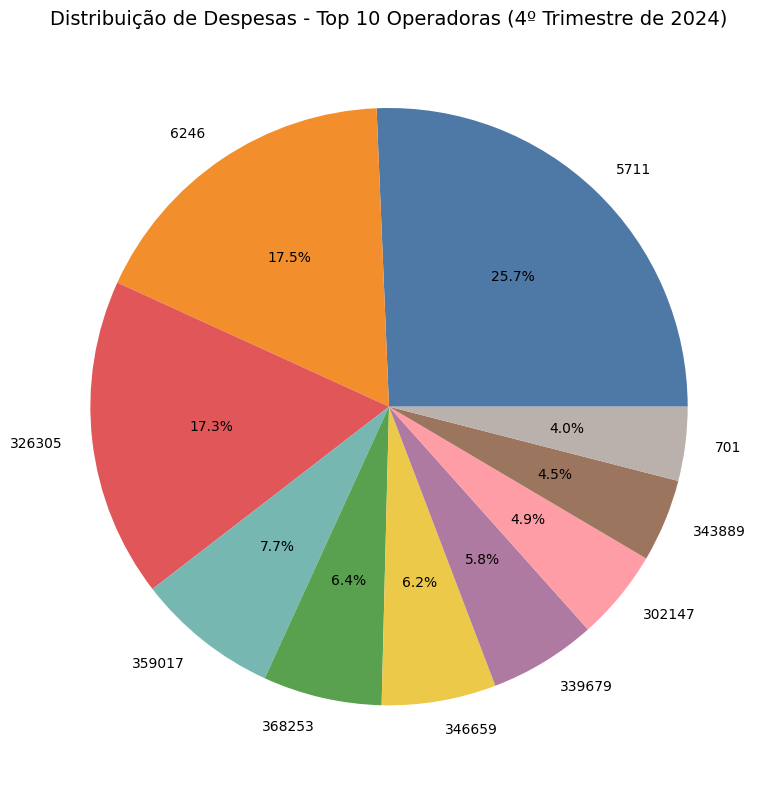

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

colors = [
    '#4E79A7', '#F28E2B', '#E15759', '#76B7B2', '#59A14F',
    '#EDC949', '#AF7AA1', '#FF9DA7', '#9C755F', '#BAB0AC'
]

plt.figure(figsize=(8, 8))
labels_tri = df_tri['reg_ans'].astype(str)
plt.pie(
    df_tri['total_despesa'],
    labels=labels_tri,
    autopct='%1.1f%%',
    colors=colors,
    textprops={'fontsize': 10}
)
plt.title("Distribuição de Despesas - Top 10 Operadoras (4º Trimestre de 2024)", fontsize=14)
plt.tight_layout()
plt.show()

# Top 10 operadoras com maiores despesas no 4º Trimestre de 2024

Consulta SQL disponível em: `content/banco_de_dados/scripts/analises.sql`

| reg_ans | total_despesa      |
|---------|--------------------|
| 5711    | 30.941.700.000,00  |
| 6246    | 21.124.940.000,00  |
| 326305  | 20.820.820.000,00  |
| 359017  | 9.307.980.000,00   |
| 368253  | 7.755.563.000,00   |
| 346659  | 7.459.368.000,00   |
| 339679  | 7.002.488.000,00   |
| 302147  | 5.920.615.000,00   |
| 343889  | 5.411.476.000,00   |
| 701     | 4.824.024.000,00   |

O gráfico acima demonstra a parcela de gastos relativos das 10 operadoras com maiores gastos em Eventos/Sinistros no último trimestre de 2024.

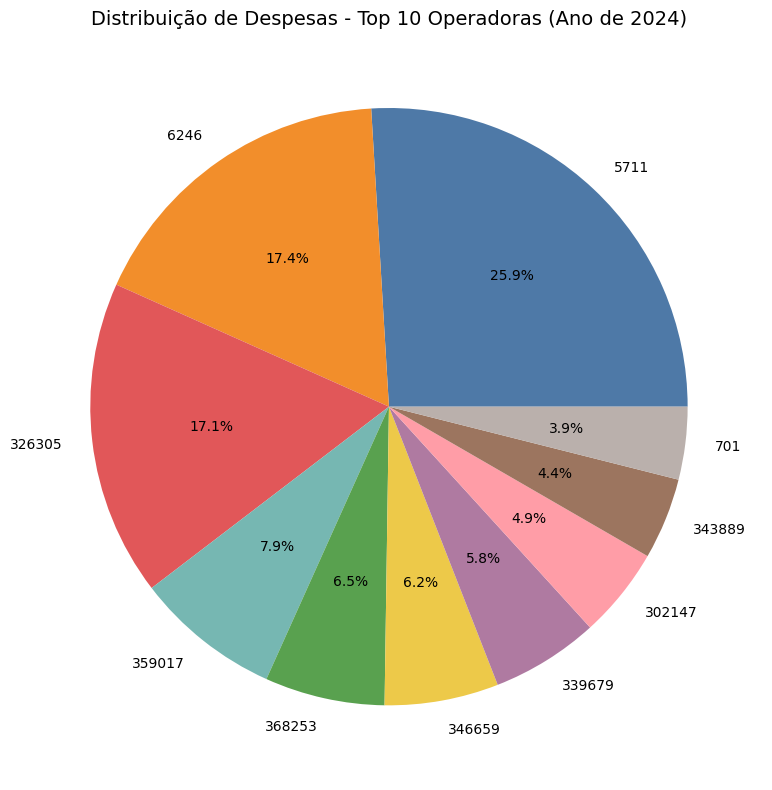

In [11]:
plt.figure(figsize=(8, 8))
labels_ano = df_ano['reg_ans'].astype(str)
plt.pie(
    df_ano['total_despesa'],
    labels=labels_ano,
    autopct='%1.1f%%',
    colors=colors,
    textprops={'fontsize': 10}
)
plt.title("Distribuição de Despesas - Top 10 Operadoras (Ano de 2024)", fontsize=14)
plt.tight_layout()
plt.show()

#Top 10 operadoras com maiores despesas do ano de 2024

Consulta SQL disponível em: `content/banco_de_dados/scripts/analises.sql`

| reg_ans | total_despesa      |
|---------|--------------------|
| 5711    | 77.467.610.000,00  |
| 6246    | 51.812.850.000,00  |
| 326305  | 51.005.560.000,00  |
| 359017  | 23.545.740.000,00  |
| 368253  | 19.385.530.000,00  |
| 346659  | 18.412.180.000,00  |
| 339679  | 17.391.270.000,00  |
| 302147  | 14.635.640.000,00  |
| 343889  | 13.162.050.000,00  |
| 701     | 11.738.000.000,00  |

O gráfico acima é relativo às 10 operadoras que tiveram maiores gastos no ano de 2024

In [8]:
# Verificação dos totais de despesas
print("Total de despesas (4º Trimestre de 2024):", df_tri['total_despesa'].sum())
print("Total de despesas (Ano de 2024):", df_ano['total_despesa'].sum())

Total de despesas (4º Trimestre de 2024): 120568974000
Total de despesas (Ano de 2024): 298556430000


#Etapa 3 encerrada